<a href="https://colab.research.google.com/github/rontalapoojareddy/DeepLearning1/blob/main/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment-5**

  **2503B05130**

  **R.Pooja Reddy**

  **M.Tech (CSE)**

**1. Imports**

In [1]:
# ================== 1. Imports ==================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


**2. Dataset**

In [2]:
# ================== 2. Dataset ==================
def get_mnist_dataloader(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),                 # [0,1]
        transforms.Normalize((0.5,), (0.5,))   # [-1,1]
    ])

    train_dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    test_dataset = datasets.MNIST(
        root="./data", train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = get_mnist_dataloader()

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.24MB/s]


**3. UNet Model**

In [3]:
# ================== 3. UNet Model ==================
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.down1 = DoubleConv(1, 64)
        self.down2 = DoubleConv(64, 128)
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.middle = DoubleConv(128, 128)

        # Decoder
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv_up2 = DoubleConv(64 + 128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.down1(x)              # [B,64,28,28]
        d2 = self.down2(self.pool(d1))  # [B,128,14,14]

        mid = self.middle(self.pool(d2))  # [B,128,7,7]

        u2 = self.up2(mid)              # [B,64,14,14]

        if u2.shape[2:] != d2.shape[2:]:
            d2 = F.interpolate(d2, size=u2.shape[2:])

        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv_up2(u2)

        out = F.interpolate(u2, size=(28, 28))
        out = self.out(out)
        return out

model = UNet().to(device)


**4. Noise Function**

In [4]:
# ================== 4. Noise Function ==================
def add_noise(x, sigma):
    noise = torch.randn_like(x)
    return x + sigma * noise

**5. Denoising Loss**

In [5]:
# ================== 5. Denoising Loss ==================
def denoising_loss(model, clean, sigma):
    noisy = add_noise(clean, sigma)
    pred = model(noisy)
    return F.mse_loss(pred, clean)

**6. Training**

In [6]:
# ================== 6. Training ==================
optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 10   # increase to 20 for even better results

for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader)

    for x, _ in pbar:
        x = x.to(device)
        sigma = torch.rand(1).item() * 0.5

        loss = denoising_loss(model, x, sigma)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

torch.save(model.state_dict(), "mnist_denoising_unet.pth")
print("Model saved as mnist_denoising_unet.pth")


Epoch 1/10 | Loss: 0.0658: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]
Epoch 2/10 | Loss: 0.0700: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]
Epoch 3/10 | Loss: 0.0710: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]
Epoch 4/10 | Loss: 0.0663: 100%|██████████| 469/469 [00:23<00:00, 19.72it/s]
Epoch 5/10 | Loss: 0.0684: 100%|██████████| 469/469 [00:23<00:00, 19.87it/s]
Epoch 6/10 | Loss: 0.0657: 100%|██████████| 469/469 [00:23<00:00, 19.91it/s]
Epoch 7/10 | Loss: 0.0683: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]
Epoch 8/10 | Loss: 0.0696: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]
Epoch 9/10 | Loss: 0.0715: 100%|██████████| 469/469 [00:23<00:00, 19.94it/s]
Epoch 10/10 | Loss: 0.0661: 100%|██████████| 469/469 [00:23<00:00, 19.63it/s]


Model saved as mnist_denoising_unet.pth


**7. Evaluation**

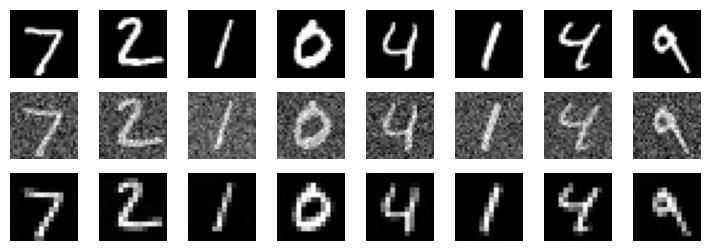

In [7]:
# ================== 7. Evaluation ==================
model.eval()
x, _ = next(iter(test_loader))
x = x.to(device)

noisy = add_noise(x, sigma=0.4)
denoised = model(noisy)

plt.figure(figsize=(9, 3))

for i in range(8):
    # Original
    plt.subplot(3, 8, i + 1)
    plt.imshow(x[i][0].cpu(), cmap="gray")
    plt.axis("off")

    # Noisy
    plt.subplot(3, 8, i + 9)
    plt.imshow(noisy[i][0].cpu(), cmap="gray")
    plt.axis("off")

    # Denoised
    plt.subplot(3, 8, i + 17)
    plt.imshow(denoised[i][0].detach().cpu(), cmap="gray")
    plt.axis("off")

plt.show()

**8.Accuracy Evaluation**

In [8]:
import math
def psnr(pred, target):
    mse = F.mse_loss(pred, target)
    if mse.item() == 0:
        return torch.tensor(100.0)
    return 20 * torch.log10(2.0 / torch.sqrt(mse))
# ================== Accuracy Evaluation ==================
model.eval()

total_mse = 0.0
total_psnr = 0.0
num_batches = 0

def psnr(pred, target):
    mse = F.mse_loss(pred, target)
    if mse.item() == 0:
        return torch.tensor(100.0)
    return 20 * torch.log10(2.0 / torch.sqrt(mse))

with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)

        noisy = add_noise(x, sigma=0.4)
        denoised = model(noisy)

        mse = F.mse_loss(denoised, x).item()
        total_mse += mse
        total_psnr += psnr(denoised, x).item()
        num_batches += 1

avg_mse = total_mse / num_batches
avg_psnr = total_psnr / num_batches

print("===================================")
print(f"Average MSE        : {avg_mse:.6f}")
print(f"Accuracy (PSNR)    : {avg_psnr:.2f} dB")
print("===================================")


Average MSE        : 0.069078
Accuracy (PSNR)    : 17.63 dB


**9.Metrics**

In [9]:
# ================== Metrics ==================

def mse_metric(img1, img2):
    return F.mse_loss(img1, img2).item()

def psnr_metric(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse)).item()

**10. Evaluation**

In [10]:
# ================== 10. Evaluation ==================
model.eval()

x, _ = next(iter(test_loader))
x = x.to(device)

# Choose noise level
sigma = 0.4
print(f"\nNoise Level Added (sigma): {sigma}")

# Add noise
noisy = add_noise(x, sigma=sigma)

# Denoise
denoised = model(noisy)


Noise Level Added (sigma): 0.4


**11.Metrics Calculation**

In [11]:
# ================== 11.Metrics Calculation ==================

mse_noisy = mse_metric(x, noisy)
mse_denoised = mse_metric(x, denoised)

psnr_noisy = psnr_metric(x, noisy)
psnr_denoised = psnr_metric(x, denoised)

print("\n===== DENOISING METRICS =====")
print(f"MSE (Original vs Noisy)     : {mse_noisy:.4f}")
print(f"MSE (Original vs Denoised) : {mse_denoised:.4f}")
print(f"PSNR Noisy     : {psnr_noisy:.2f} dB")
print(f"PSNR Denoised  : {psnr_denoised:.2f} dB")



===== DENOISING METRICS =====
MSE (Original vs Noisy)     : 0.1603
MSE (Original vs Denoised) : 0.0673
PSNR Noisy     : 7.95 dB
PSNR Denoised  : 11.72 dB


**12.Original,Noisy,Denoised Images and Values**

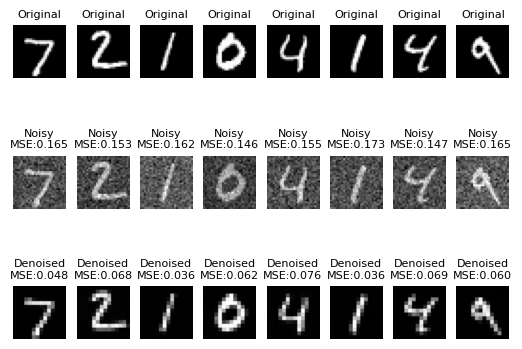

In [12]:
for i in range(8):

    mse_n = F.mse_loss(x[i], noisy[i]).item()
    mse_d = F.mse_loss(x[i], denoised[i]).item()

    # Original
    plt.subplot(3, 8, i + 1)
    plt.imshow(x[i][0].cpu(), cmap="gray")
    plt.title("Original", fontsize=8)
    plt.axis("off")

    # Noisy
    plt.subplot(3, 8, i + 9)
    plt.imshow(noisy[i][0].cpu(), cmap="gray")
    plt.title(f"Noisy\nMSE:{mse_n:.3f}", fontsize=8)
    plt.axis("off")

    # Denoised
    plt.subplot(3, 8, i + 17)
    plt.imshow(denoised[i][0].detach().cpu(), cmap="gray")
    plt.title(f"Denoised\nMSE:{mse_d:.3f}", fontsize=8)
    plt.axis("off")


**13.Sigma**

In [13]:
for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:

    noisy = add_noise(x, sigma)
    denoised = model(noisy)

    mse_d = mse_metric(x, denoised)
    psnr_d = psnr_metric(x, denoised)

    print(f"\nSigma: {sigma}")
    print(f"MSE  : {mse_d:.4f}")
    print(f"PSNR : {psnr_d:.2f} dB")



Sigma: 0.1
MSE  : 0.0644
PSNR : 11.91 dB

Sigma: 0.2
MSE  : 0.0650
PSNR : 11.87 dB

Sigma: 0.3
MSE  : 0.0660
PSNR : 11.80 dB

Sigma: 0.4
MSE  : 0.0674
PSNR : 11.72 dB

Sigma: 0.5
MSE  : 0.0693
PSNR : 11.59 dB
